In [1]:
# Notebook to test completed ML model v3
# Uses all negatiove links
# Test model link prediction and community detection features
# Test triangles and clustering

In [2]:
from py2neo import Graph
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import pandas as pd
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
graph = Graph("bolt://localhost", auth=("neo4j", "123"))
import pickle

In [3]:
filename = 'd:\projectdata\Models\CDMLWU_V7.sav'
lrclassifier = pickle.load(open(filename,'rb'))
# Feature column names
columns = [
    "cn","aa", "pa", "tn","ra", # graph features
    "minT", "maxT", "minC", "maxC", # triangle features     
    "sn"                            # same name feature
]

In [4]:
#Function to down sample negative examples
def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0]
    un = Counter(copy.label.values)[1]
    n = zero - un
    copy = copy.drop(copy[copy.label == 0].sample(n=n, random_state=1).index)
    return copy.sample(frac=1)

def evaluate_model(predictions, actual):
    return pd.DataFrame({
        "Measure": ["Accuracy", "Precision", "Recall"],
        "Score": [accuracy_score(actual, predictions), 
                  precision_score(actual, predictions), 
                  recall_score(actual, predictions)]
    })

def feature_importance(columns, classifier):        
    display("Feature Importance")
    df = pd.DataFrame({
        "Feature": columns,
        "Importance": classifier.feature_importances_
    })
    df = df.sort_values("Importance", ascending=False)    
    ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
    ax.xaxis.set_label_text("")
    plt.tight_layout()
    plt.show()

In [5]:
def create_LP_features(data, rel_type):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1:Person) 
    USING INDEX p1:Person(connectionid) 
    WHERE p1.connectionid = pair.node1
    MATCH (p2:Person) 
    USING INDEX p2:Person(connectionid) 
    WHERE p2.connectionid = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           algo.linkprediction.commonNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS cn,
           algo.linkprediction.adamicAdar(
               p1, p2, {relationshipQuery: $relType}) AS aa,
           algo.linkprediction.preferentialAttachment(
               p1, p2, {relationshipQuery: $relType}) AS pa,
           algo.linkprediction.totalNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS tn,
           algo.linkprediction.resourceAllocation(
               p1, p2, {relationshipQuery: $relType}) AS ra
               
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    features = graph.run(query, {"pairs": pairs, "relType": rel_type}).to_data_frame()
    features = features.drop_duplicates()
    return pd.merge(data, features, on = ["node1", "node2"])

def create_community_features(data, triangles_prop, coefficient_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1:Person) 
    USING INDEX p1:Person(connectionid) 
    WHERE p1.connectionid = pair.node1
    MATCH (p2:Person) 
    USING INDEX p2:Person(connectionid) 
    WHERE p2.connectionid = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    apoc.coll.min([p1[$trianglesProp], p2[$trianglesProp]]) AS minT,
    apoc.coll.max([p1[$trianglesProp], p2[$trianglesProp]]) AS maxT,
    apoc.coll.min([p1[$coefficientProp], p2[$coefficientProp]]) AS minC,
    apoc.coll.max([p1[$coefficientProp], p2[$coefficientProp]]) AS maxC
    """    
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]    
    params = {
    "pairs": pairs,
    "trianglesProp": triangles_prop,
    "coefficientProp": coefficient_prop
    }
    features = graph.run(query, params).to_data_frame()
    features = features.drop_duplicates()
    return pd.merge(data, features, on = ["node1", "node2"])

def communitydetection_features(data, partition_prop, louvain_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1:Person) 
    USING INDEX p1:Person(connectionid) 
    WHERE p1.connectionid = pair.node1
    MATCH (p2:Person) 
    USING INDEX p2:Person(connectionid) 
    WHERE p2.connectionid = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    algo.linkprediction.sameCommunity(p1, p2, $partitionProp) AS lp,    
    algo.linkprediction.sameCommunity(p1, p2, $louvainProp) AS lv
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    params = {
    "pairs": pairs,
    "partitionProp": partition_prop,
    "louvainProp": louvain_prop
    }
    features = graph.run(query, params).to_data_frame()
    features = features.drop_duplicates()
    return pd.merge(data, features, on = ["node1", "node2"])

def samename_features(data, samename_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1:Person) 
    USING INDEX p1:Person(connectionid) 
    WHERE p1.connectionid = pair.node1
    MATCH (p2:Person) 
    USING INDEX p2:Person(connectionid) 
    WHERE p2.connectionid = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    algo.linkprediction.sameCommunity(p1, p2, $samenameProp) AS sn
"""
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    params = {
    "pairs": pairs,
    "samenameProp": samename_prop
    }
    features = graph.run(query, params).to_data_frame()
    features = features.drop_duplicates()
    return pd.merge(data, features, on = ["node1", "node2"])

In [6]:
#Load data
load_links = graph.run("""
MATCH (p1:Person {FullName: 'Jamil Lendon' })-[*1..2]-(p2:Person)-[:Knows]-(p3:Person)
RETURN p2.connectionid AS node1, p3.connectionid AS node2, 1 AS label
""").to_data_frame()

In [7]:
load_links= load_links.drop_duplicates()

In [8]:
#Load missing link data 
nolinks = pd.read_csv('d:/projectdata/ModelInput/noedges.csv')

In [9]:
# Add the nodes with no link
all_links = load_links.append(nolinks,ignore_index=True)

In [10]:
# Apply graphs algorithms to node pairs
# use the main graph not a sub-graph
all_links= create_LP_features(all_links,"Knows")

In [11]:
# Apply Triangle features to node pairs
# Setup data in graphDB
graph.run("""
CALL algo.triangleCount('Person', 'Knows', { write:true,
writeProperty:'triangles', clusteringCoefficientProperty:'clustercoef'});
""").to_data_frame()

all_links = create_community_features(all_links,"triangles","clustercoef")

In [12]:
# Use the same surname feature extractor
all_links = samename_features(all_links, "surnameID")

In [13]:
all_links.to_csv('d:/projectdata/ModelOutput//ModelData/CDMLWU_V7_JLPOS.csv')

In [14]:
predictions=lrclassifier.predict(all_links[columns])
predictpct=lrclassifier.predict_proba(all_links[columns])

In [15]:
pd.DataFrame(predictions).to_csv('d:/projectdata/ModelOutput/ModelData/CDMLWU_V7_JLPOS_P.csv')

In [16]:
pd.DataFrame(predictpct).to_csv('d:/projectdata/ModelOutput/ModelData/CDMLWU_V7_JLPOS_PCT.csv')

,Measure,Score
0,Accuracy,0.778
1,Precision,0.961
2,Recall,0.789


'Feature Importance'

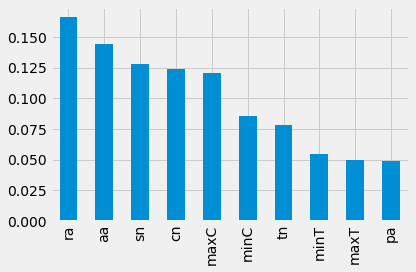

In [17]:
y_test = all_links["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, lrclassifier)